# MOS Differential Pair

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import time

from circulus.solvers.strategies import KLUSolver
from circulus.components import Resistor, VoltageSource, CurrentSource, NMOS
from circulus.compiler import compile_netlist

1. Compiling...
2. Running Sweep (200 points)...
Sweeping DC Operating Point (with Continuation)...
Simulation Time: 0.775s


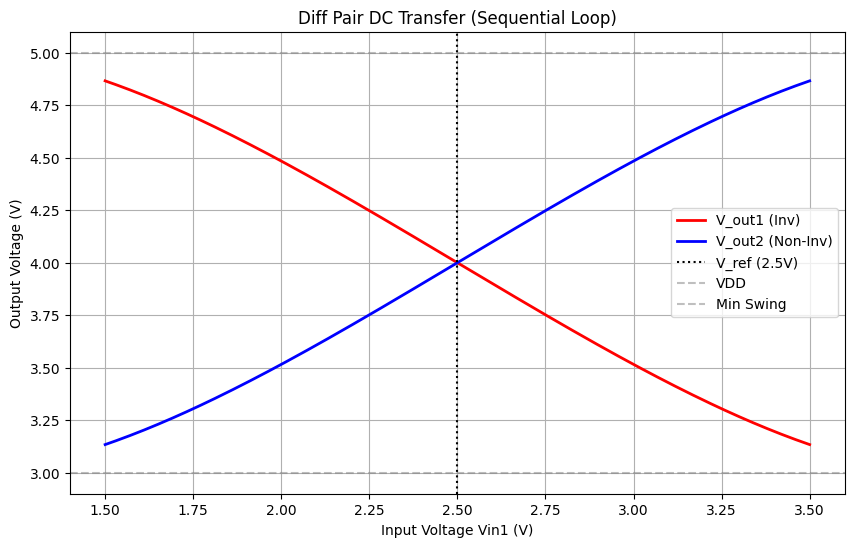

✅ Verification: Outputs look non-zero. Check plot geometry.


In [4]:
def update_param_value(groups, group_name, instance_name, param_key, new_value):
    g = groups[group_name]
    
    instance_idx = g.index_map[instance_name]
    
    batched_comp = g.params
    current_vals = getattr(batched_comp, param_key)
    
    new_vals = current_vals.at[instance_idx].set(new_value)
    
    new_batched_comp = eqx.tree_at(lambda c: getattr(c, param_key), batched_comp, new_vals)
    new_g = eqx.tree_at(lambda g: g.params, g, new_batched_comp)
    
    new_groups = groups.copy()
    new_groups[group_name] = new_g
    return new_groups

jax.config.update("jax_enable_x64", True)

models_map ={
    'nmos': NMOS,
    'resistor': Resistor,
    'source_dc': VoltageSource,
    'current_src': CurrentSource,
    'ground': lambda: 0
}

net_dict ={
    "instances": {
        "GND": {"component":"ground"},
        "VDD": {"component":"source_dc", "settings":{"V": 5.0}},
        "Iss": {"component":"current_src", "settings":{"I": 1e-3}},
        "RD1": {"component":"resistor", "settings":{"R": 2000}},
        "RD2": {"component":"resistor", "settings":{"R": 2000}},
        "M1":  {"component":"nmos", "settings":{"W": 50e-6, "L": 1e-6}},
        "M2":  {"component":"nmos", "settings":{"W": 50e-6, "L": 1e-6}},
        "Vin1": {"component":"source_dc", "settings":{"V": 1.5}},
        "Vin2": {"component":"source_dc", "settings":{"V": 2.5}},
    },
    "connections": {
        "GND,p1": ("VDD,p2", "Vin1,p2", "Vin2,p2", "Iss,p2"),
        "Iss,p1": ("M1,s", "M2,s"),
        "M1,d": "RD1,p2",
        "M2,d": "RD2,p2",
        "RD1,p1": "VDD,p1",
        "RD2,p1": "VDD,p1",
        "Vin1,p1": "M1,g",
        "Vin2,p1": "M2,g",
    },
}

print("1. Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

linear_strat = KLUSolver.from_circuit(groups, sys_size, is_complex=False)

@jax.jit
def scan_step(y_prev, v_in_val):
    new_groups = update_param_value(groups, 'source_dc', 'Vin1', 'V', v_in_val)
    y_sol = linear_strat.solve_dc(new_groups, y_guess=y_prev)
    return y_sol, y_sol

sweep_voltages = jnp.linspace(1.5, 3.5, 200)

print(f"2. Running Sweep ({len(sweep_voltages)} points)...")
print("Sweeping DC Operating Point (with Continuation)...")
start_time = time.time()

y_current = jnp.zeros(sys_size)
final_y, solutions = jax.lax.scan(scan_step, y_current, sweep_voltages)

total = time.time() - start_time
print(f"Simulation Time: {total:.3f}s")

idx_out1 = port_map["RD1,p2"]
idx_out2 = port_map["RD2,p2"]

v_out1 = solutions[:, idx_out1]
v_out2 = solutions[:, idx_out2]

plt.figure(figsize=(10, 6))
plt.plot(sweep_voltages, v_out1, 'r-', linewidth=2, label='V_out1 (Inv)')
plt.plot(sweep_voltages, v_out2, 'b-', linewidth=2, label='V_out2 (Non-Inv)')

plt.axvline(2.5, color='k', linestyle=':', label='V_ref (2.5V)')
plt.axhline(5.0, color='gray', linestyle='--', alpha=0.5, label='VDD')
plt.axhline(5.0 - (1e-3 * 2000), color='gray', linestyle='--', alpha=0.5, label='Min Swing')

plt.title("Diff Pair DC Transfer (Sequential Loop)")
plt.xlabel("Input Voltage Vin1 (V)")
plt.ylabel("Output Voltage (V)")
plt.legend()
plt.grid(True)
plt.show()

if jnp.all(v_out1 == 0):
    print("❌ ERROR: Output is all zeros. Solver did not converge or model is broken.")
else:
    print("✅ Verification: Outputs look non-zero. Check plot geometry.")